In [9]:
%%writefile -a song_recommender.py

import numpy as np
import pandas as pd
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
from time import sleep
from spotify_client import *

def search_song():
    '''function that receives an input of song name and artist and
    searches for results in spotify, gives an output of 5 options to choose
    and returns song_id'''
    
    title = input('Write the song name:').lower()
    artist = input('Write the artist name:').lower()
    
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= client_id,
                                                           client_secret= client_secret))
    
    results = sp.search(q="track:"+title+" artist:"+artist,limit=5)
    
    n = 1
    if results['tracks']['items'] != []:
        for item in results['tracks']['items']:
            print("{}: The name of song is: '{}' and the artist is: {}".format(n, item['name'],item['artists'][0]['name']))
            n += 1
        
        number = int(input('\n Please type the number of your selection:'))
        
        print('\n You selected {} from {}'.format(results['tracks']['items'][(number-1)]['name'], 
                                                  results['tracks']['items'][(number-1)]['artists'][0]['name']))
    
        song_id = results['tracks']['items'][(number-1)]['id']
        
    else: 
        song_id = 'error'
        print('Your search didnt retrieve results')
    
    return song_id

Writing song_recommender.py


In [10]:
%%writefile -a song_recommender.py

def get_x_scaled(song_id):
    
    sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= client_id,
                                                           client_secret= client_secret))
    
    song_features = pd.DataFrame(sp.audio_features(song_id))
    
    x = song_features[['danceability','energy', 'speechiness', 'tempo', 'duration_ms']]
    
    scaler = pd.read_pickle('scaler.pkl')
    
    x_scaled  = pd.DataFrame(scaler.transform(x), columns=x.columns)
    
    return x_scaled

Appending to song_recommender.py


In [11]:
%%writefile -a song_recommender.py

def get_cluster(x_scaled):
    
    model = pd.read_pickle('models/kmeans_19.pickle')
    
    yhat = int(model.predict(x_scaled))
    
    return yhat

Appending to song_recommender.py


In [12]:
%%writefile -a song_recommender.py

from sklearn.utils import shuffle

def suggested_song(cluster, song_id):
    
    ### reading database
    
    db = pd.read_csv('dbkmeans.csv').iloc[:,1:]
    
    ## deleting searched song from database, if it is there
    
    if song_id in db['id'].values: 
        song_index = db[db['id'] == song_id].index.item()
        option = db.drop(db.index[song_index], axis=0)
    else: 
        option = db

    ## selecting cluster (hot/not hot)
        
    if song_id in db[db['hot'] == 'Yes']['id'].values: 
        hot = 'Yes'
        print('This is a hot song!')
    else: 
        hot = 'No'

    option = option[ (option['hot'] == hot) & (option['kmeans'] == cluster)].reset_index(drop=True)
    option = shuffle(option).reset_index(drop=True)
    
    ## making loop of suggestions
    
    answer= 'y'
    n= 0    
    
    while answer == 'y' and n<len(option):

        option_one = option.loc[n,:]
        
        link = 'https://open.spotify.com/track/'+option_one['id']

        print('\n We think you will like this song: \n', option_one['title'],
                  'from \n', option_one['artist'], '\n Listen on',link)

    ## conditions to stop/ continue loop
    
        if (n + 1) == len(option):
            print('\n This was our available last suggestion.')
            answer = 'n'
            
        else:
            answer = input('\n Do you want to receive another suggestion [y/n]')
            
            while answer != 'y' and answer != 'n': 
                print('\n Please, input a valid answer.')
                answer = input('\n Do you want to receive another suggestion [y/n]')

            if answer == 'n': 
                print('\n We hope you are happy!')  
            
        n +=1
        
    return answer

Appending to song_recommender.py


In [13]:
%%writefile -a song_recommender.py

def get_image(cluster):
    
    mood = ['Trendy', 'Neon', 'Workout', 'Melancholic', 
        'Worldly', 'Urbano', 'Songs to sing in th shower', 'Thunder',
        'Happy', 'Alive', 'Golden', 'Cozy blend', 'Summer', 'Dance', 
        'Arepas', 'Mellow', 
        'Anything can happen', 'Calm', 'Mood booster']
    image = ['trendy.jpg','hip_pop.jpg','energy.jpg','melancolic.jpg',
        'worldly.jpg','rap.jpg','sing_shower.jpg', 'thunder.jpg',
         'happy.jpg','alive.jpg','golden.jpg','cozy_blend.jpg',
        'summer.jpg','dance.jpg','arepas.jpg','mellow.jpg',
        'anything.jpg','calm.jpg','mood_booster.jpg']
    
    mood_img = pd.DataFrame()    
    mood_img['mood'] = mood
    mood_img['image'] = image

    mood = mood_img['mood'].loc[cluster]
    image_name = 'photos/'+mood_img['image'].loc[cluster]

    
    return mood, image_name

Appending to song_recommender.py


In [14]:
%%writefile -a song_recommender.py

from IPython.display import Image, display

def song_recommender():

    display(Image('logo.png', width=800))
    
    song_id = search_song()
    
    if song_id != 'error':
        x_scaled = get_x_scaled(song_id)
        cluster = get_cluster(x_scaled)
        mood, image = get_image(cluster)
        
        print('\n Your mood is {}'.format(mood))
        display(Image(image, width=300))
        
        suggested_song(cluster, song_id)
    
    return print('\n Thank you!') 

Appending to song_recommender.py


In [15]:
%run song_recommender.py

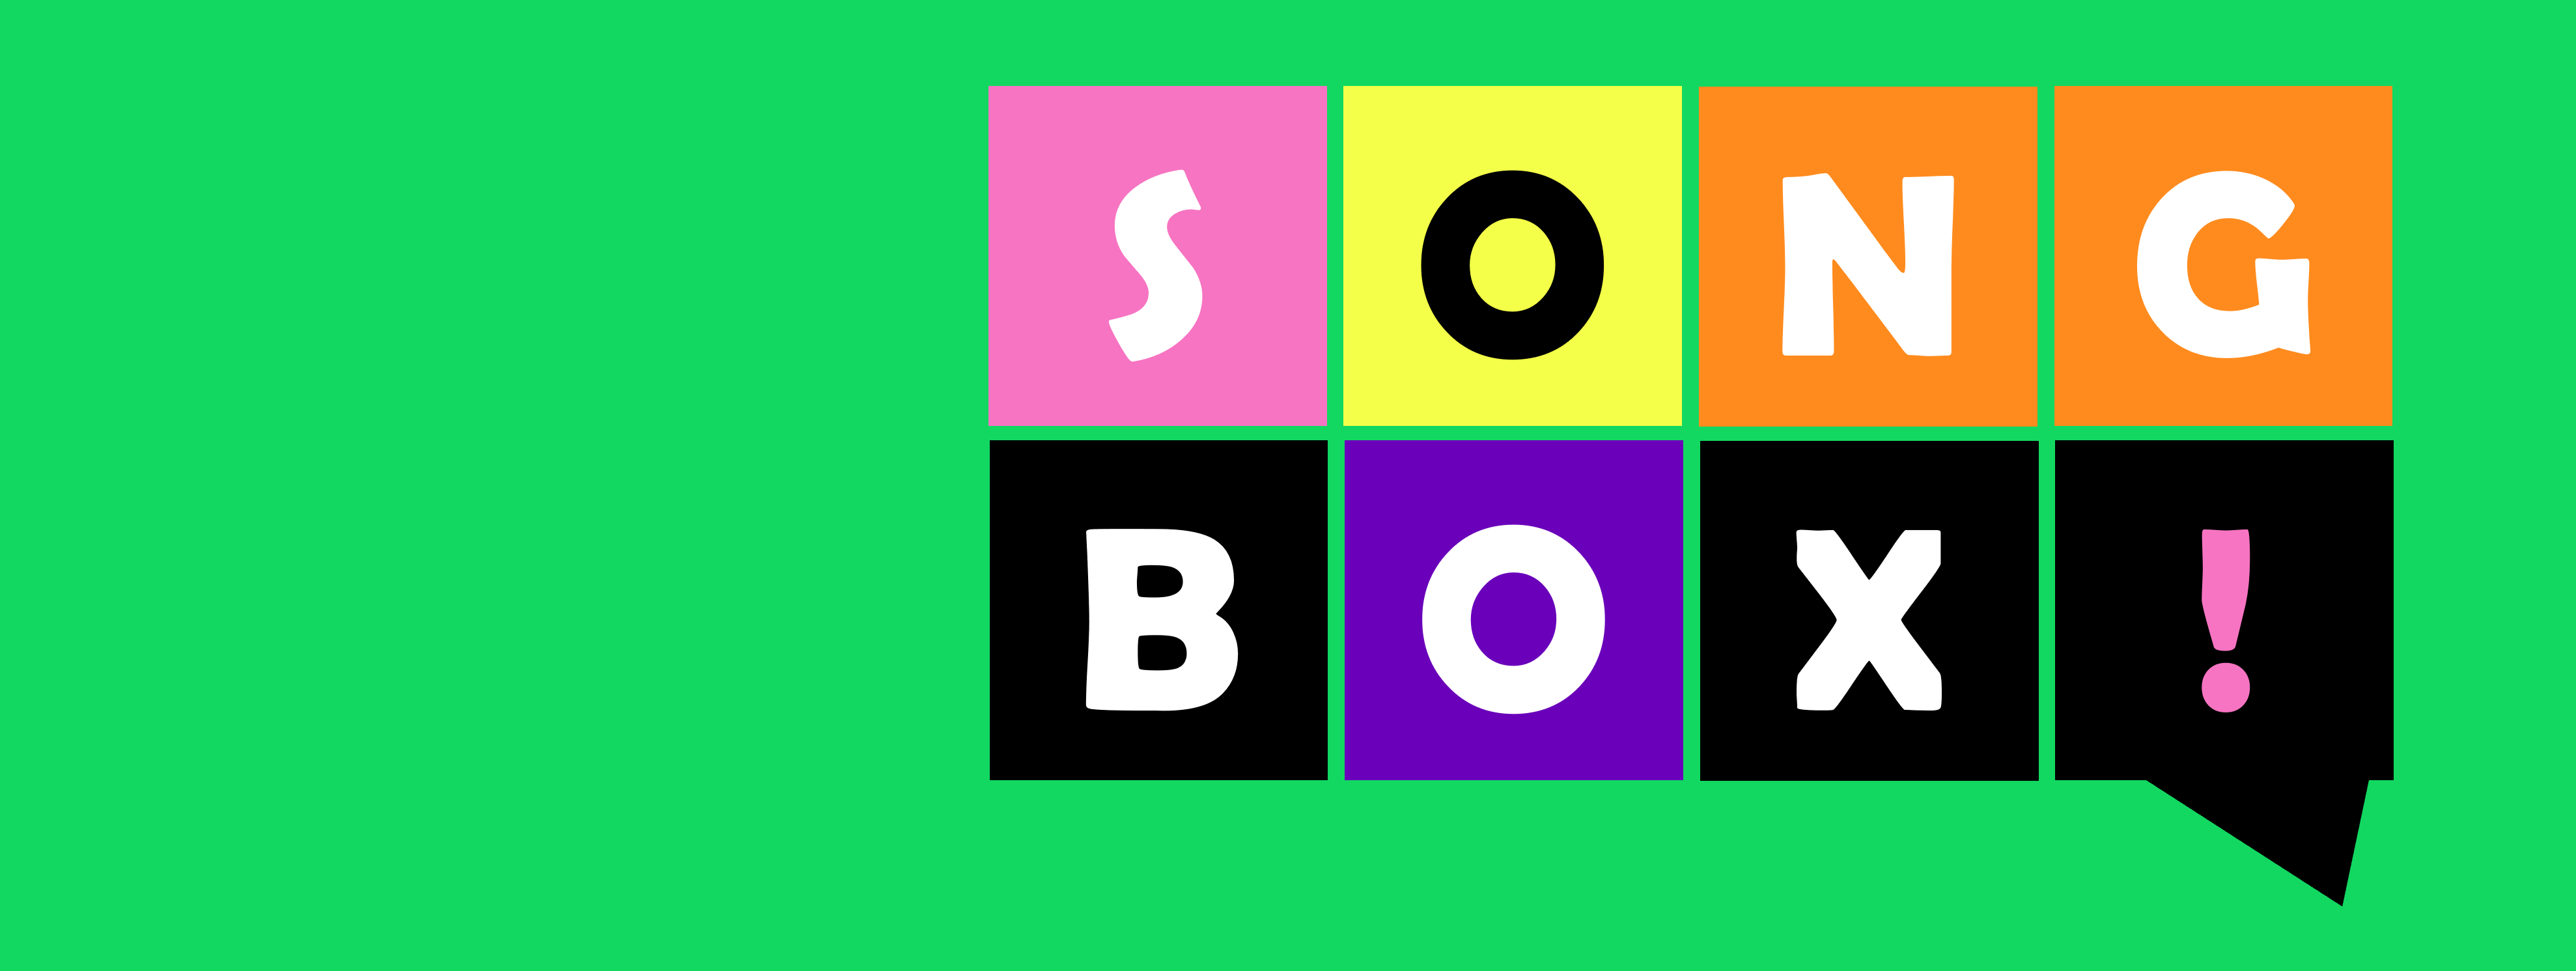

Write the song name:uhhhhhjjjhhj
Write the artist name:jjhvkytkyjbyt
Your search didnt retrieve results

 Thank you!


In [16]:
song_recommender()